# Visualizations
This notebook generates the experimental plots and images used in our thesis. 

## Setup and Imports

In [1]:
# Obtaining the path to this directory
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)
print(f"Path to this directory; {root_dir}")

# General Imports
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Importing from Vaze et al.'s code
from osr_closed_set_all_you_need_main.data.tinyimagenet import TinyImageNet

# Importing our own tools
from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.eval_tools import balance_binary, get_osr_targets, osr_splits

from our_modules.plot_tools import plot_roc
from our_modules.plot_tools import plot_image
from our_modules.plot_tools import EpsExperimentPlot, EpsExperimentPlotMedian
from our_modules.plot_tools import IdOodPlot
from our_modules.plot_tools import plot_diff_stats_for_eps
from our_modules.plot_tools import plot_adv_imgs
from our_modules.plot_tools import plot_ranked_scores
from our_modules.plot_tools import plot_image_i

from our_modules.tin_tools import test_transform as tin_test_transform
from our_modules.tin_tools import mean as tin_mean, std as tin_std
from our_modules.tin_tools import perturb_tin_image

from our_modules.adv_tools import fn_osr_fgsm, fp_osr_fgsm
from our_modules.adv_tools import fn_osr_itat, fp_osr_itat
from our_modules.adv_tools import fn_osr_fgsm_max, fn_osr_itat_max

# Optaining the device for computing
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")
print("Device:", device)

# Some global variables. Mainly paths.
tin_dataset = TinyImageNet(root_dir + 'datasets/tiny-imagenet-200/val/images/', transform=tin_test_transform)
idx_goldfish, idx_panda = 9, 2915
tin_goldfish = tin_dataset[idx_goldfish][0] # Novel in split 0
tin_panda = tin_dataset[idx_panda][0] # Familiar in split 0
tin_grad_norm_dir = root_dir + 'grad_norms/tinyimagenet/'
tin_logits_dir = root_dir + "logits/tinyimagenet/"
path_to_pretrained_weights_folder = root_dir + 'osr_closed_set_all_you_need_main/pretrained_weights/'
vis_log = root_dir + 'visualizations_paper/png/'
file_name_list = []

# Determining some statistics of the MLS on D_test
def find_max_min(balanced):
    split = osr_splits['tinyimagenet'][0]
    plain_logits_0 = torch.load(tin_logits_dir + 'plain/logits_0.pt')
    plain_targets_0 = torch.load(tin_logits_dir + 'plain/csr_targets_0.pt')
    osr_targets = get_osr_targets(plain_targets_0, split)
    max_logits = torch.amax(plain_logits_0, dim=-1)
    if balanced:
        zipped = balance_binary(zip(max_logits,osr_targets),  lambda x: bool(x[1]))
        max_logits, osr_targets = zip(*zipped)
    max_logits = sorted(max_logits)
    largest_mls = max_logits[-1]
    smallest_mls = max_logits[0]
    ninetyfith = max_logits[int(len(max_logits)*0.99)]
    first = max_logits[int(len(max_logits)*0.01)]
    # print('largest', largest_mls)
    # print('smallest', smallest_mls)
    # print('99th', ninetyfith)
    # print('1st', first)
    return (largest_mls, smallest_mls, ninetyfith, first)

largest_mls, smallest_mls, ninetyfith_percentile, first_percentile = find_max_min(True)

Path to this directory; /Users/gunder/Desktop/bachelor_project/
Device: mps


## Showing the image examples from D_test

## Adversarial Attacks

### Figure 13

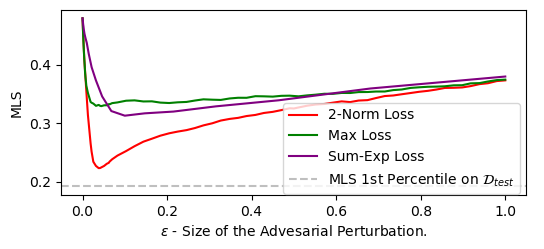

In [2]:
# FP attack comparison
# change scale
sc = 0.6
file_name = 'mls_comp_fgsm_fp'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False, eps_figsize=(10*sc, 4*sc))
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=1.001, c='red')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/max/', 0, True, label_suffix= 'Max Loss', max_eps=1.001, c='green')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= 'Sum-Exp Loss', max_eps=1.001, c='purple')
comparison_exp_2.set_legend_and_highlight_eps(legend_loc=(0.52, 0.22), h_line=first_percentile, label_h='MLS 1st Percentile on $\mathcal{D}_{test}$')
comparison_exp_2.show_and_save(vis_log + file_name)

### Figure 10

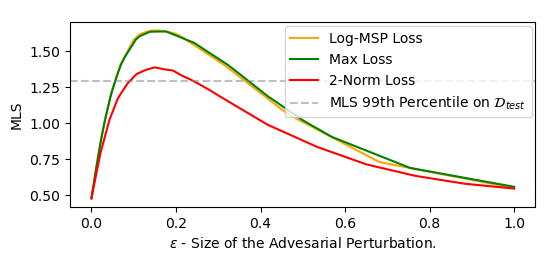

In [3]:
# change scale
sc = 0.6
file_name = 'mls_comp_fgsm_fn'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False, eps_figsize=(sc*10, sc*4))
max_eps = 1.001
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= 'Log-MSP Loss', max_eps = max_eps, c='orange')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix='Max Loss', max_eps = max_eps, c='green')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/two_norm/', 0, True, label_suffix= '2-Norm Loss', max_eps = max_eps,c='red')
# comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= 'Sum_Exp', max_eps = max_eps)
comparison_exp_2.set_legend_and_highlight_eps(legend_loc=(0.51, 0.55), h_line=ninetyfith_percentile, label_h='MLS 99th Percentile on $\mathcal{D}_{test}$')
comparison_exp_2.show_and_save(vis_log + file_name)

### Figure 15

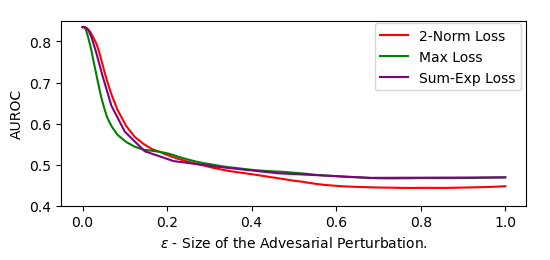

In [4]:
sc = 0.6
file_name = 'auroc_comp_fgsm_fp'
file_name_list.append(file_name)
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC', add_zoom=False, eps_figsize = (10*sc, 4*sc))
max_eps = 1.01
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix=' ; FN with Max norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=max_eps, c='red')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/max/', 0, True, label_suffix= 'Max Loss', max_eps=max_eps, c='green')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= 'Sum-Exp Loss', max_eps=max_eps, c='purple')
comparison_exp_1.set_legend_and_highlight_eps(legend_loc=(0.68, 0.65))
comparison_exp_1.show_and_save(vis_log + file_name, plt_y_lim = (0.4, 0.85))

### Figure 12

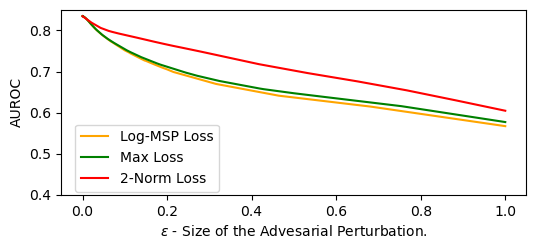

In [11]:
sc = 0.6
file_name = 'auroc_comp_fgsm_fn'
file_name_list.append(file_name)
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC',add_zoom= False,loc_zoom=1, eps_figsize=(sc*10, sc*4))
max_eps = 1.01
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= 'Log-MSP Loss', max_eps=max_eps, c= 'orange')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix='Max Loss', max_eps=max_eps, c='green')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=max_eps, c='red')
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/max/', 0, True, label_suffix= ' ; FP with Max norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss', max_eps=max_eps)
comparison_exp_1.set_legend_and_highlight_eps(legend_loc=(0.14, 0.23))
comparison_exp_1.show_and_save(vis_log + file_name, plt_y_lim = (0.4, 0.85))

### Figure 14

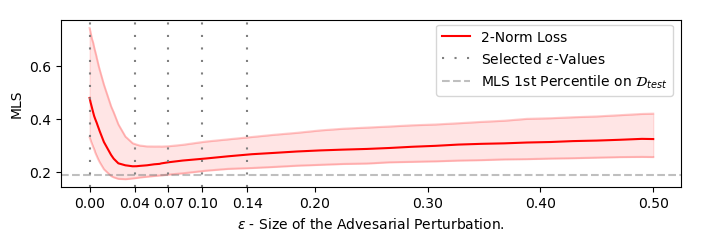

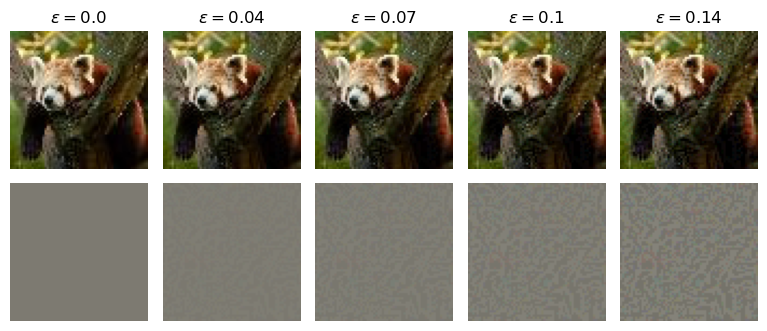

In [10]:
sc = 0.8

file_name = 'vis_pertubation_fgsm_fp_'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlotMedian(which_lines='mls', add_zoom=False, eps_figsize=(10*sc,2.7*sc), mls_title='MLS')
highlight_eps_idx = [0,20,26, 28, 30]
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=0.503, c='red')
comparison_exp_2.set_legend_and_highlight_eps(eps_idxs=highlight_eps_idx,legend_loc=(0.62, 0.6), h_line=first_percentile, label_h='MLS 1st Percentile on $\mathcal{D}_{test}$')
comparison_exp_2.show_and_save(vis_log + file_name + 'graph')
highlight_eps = comparison_exp_2.recent_eps[highlight_eps_idx]
plot_adv_imgs(highlight_eps, *perturb_tin_image(highlight_eps, tin_panda, path_to_pretrained_weights_folder, device, split_num=0, 
                                                                      attack=fn_osr_fgsm, norm_ord=torch.inf),
              mean=tin_mean, std=tin_std, fig_scale = sc2, save_path = vis_log + file_name + 'img')

### Figure 11

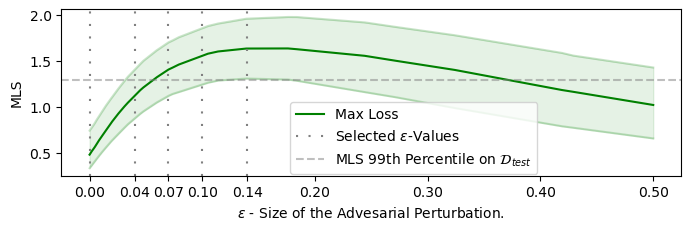

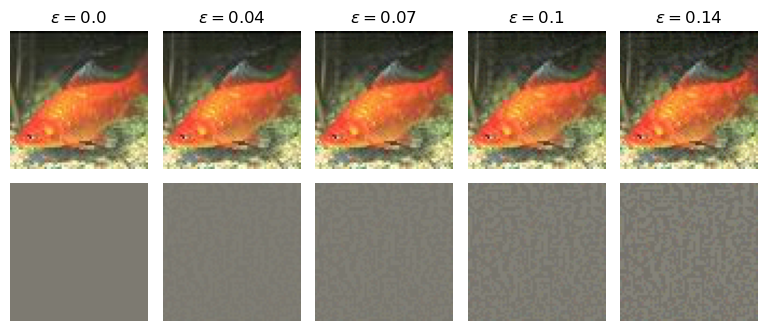

In [9]:
sc = 0.8
sc2= 0.7
file_name = 'vis_pertubation_fgsm_fn_'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlotMedian(which_lines='mls', add_zoom=False, eps_figsize=(10*sc,2.7*sc), mls_title='MLS')
highlight_eps_idx = [0,41, 45,48]
highlight_eps_idx = [0,41, 45,48, 50]
# highlight_eps_idx = [0,44,44,45,46]
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix='Max Loss', max_eps=0.501, c = 'green')
comparison_exp_2.set_legend_and_highlight_eps(eps_idxs=highlight_eps_idx,legend_loc=(0.42, 0.245), h_line=ninetyfith_percentile, label_h='MLS 99th Percentile on $\mathcal{D}_{test}$')
comparison_exp_2.show_and_save(vis_log + file_name + 'graph')
highlight_eps = comparison_exp_2.recent_eps[highlight_eps_idx]
plot_adv_imgs(highlight_eps, *perturb_tin_image(highlight_eps, tin_goldfish, path_to_pretrained_weights_folder, device, split_num=0, 
                                                                      attack=fn_osr_fgsm, norm_ord=torch.inf),
              mean=tin_mean, std=tin_std, fig_scale = sc2, save_path = vis_log + file_name + 'img')